In [ ]:
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import stft, ricker, cwt, butter, iirnotch, lfilter
import scipy.stats as stats
import pywt
from tqdm import tqdm
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

import torch

import mne

from statsmodels.stats.weightstats import ztest

In [5]:
def load_data(filepath):
    """
    Loads EEG signal from the dataset
    """
    sample_matlab_data = scio.loadmat(filepath)  # Structured Matlab Array containing all information
    return sample_matlab_data

basedir = 'Data'

In [6]:
patient_data = []
for file in os.listdir(basedir):
    filepath = os.path.join(basedir, file)
    patient_data.append(load_data(filepath))
    
print(len(patient_data))

8


In [7]:
patient_data[0]

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Nov 25 12:46:00 2014',
 '__version__': '1.0',
 '__globals__': [],
 'data': array([[(array([[array(['Fz'], dtype='<U2'), array(['Cz'], dtype='<U2'),
                 array(['Pz'], dtype='<U2'), array(['Oz'], dtype='<U2'),
                 array(['P3'], dtype='<U2'), array(['P4'], dtype='<U2'),
                 array(['PO7'], dtype='<U3'), array(['PO8'], dtype='<U3')]],
               dtype=object), array([[ -1.21978372,  -0.32769319,  -1.21995831, ...,  -2.65680554,
                   7.37202505,  -0.27890203],
                [ -1.42616224,  -4.18996393,  -5.65458822, ...,  -9.45534598,
                  -3.67053188,  -5.48506363],
                [ -1.31524453,  -6.87075831,  -8.55992067, ..., -14.26798757,
                 -11.63200572,  -8.92900433],
                ...,
                [ -3.96511643,   5.70748743,   1.11047492, ...,  -5.27998942,
                   9.13724881,  -0.85580654],
                [ -0

# Parameters of the EEG Signal

In [8]:
sample_frequency = 256 #Hz
bandpass = [0, 30] #Hz
stimulus_duration = 125 #ms // tín hiệu làm nổi bật trong 125ms
interstimulus_duration = 125 #ms // khoảng thời gian giữa các tín hiệu làm nổi bật
total_stimulus=12 #6 cột + 6 hàng
number_of_time_each_stimulus_appeared_per_trial = 10
total_stimulus_appeared_per_trial = total_stimulus * number_of_time_each_stimulus_appeared_per_trial    
trial_duration = (stimulus_duration + interstimulus_duration) * total_stimulus_appeared_per_trial - interstimulus_duration #ms
samples_per_trial = sample_frequency * trial_duration // 1000 #số mẫu trong mỗi thử nghiệm

print(f"Each trial lasts for {trial_duration}ms and contains {samples_per_trial} samples")

Each trial lasts for 29875ms and contains 7648 samples


In [9]:
def trials_of_patient(patient_data):
    """
    Returns all data of trials for a patient
    """
    data= patient_data['data'][0][0]
    signal = data['X']
    stimulus = data['y_stim']
    target = data['y']
    x=[]
    y_stimulus=[]
    y_target=[]
    trial_start = data['trial'].flatten()
    trial_end = trial_start+samples_per_trial
    for i in range(len(trial_start)):
        x.append(signal[trial_start[i]:trial_end[i]])
        y_stimulus.append(stimulus[trial_start[i]:trial_end[i]])
        y_target.append(target[trial_start[i]:trial_end[i]])
    return np.array(x), np.array(y_stimulus), np.array(y_target)

x, y_stimulus, y_target = trials_of_patient(patient_data[0])
x.shape, y_stimulus.shape, y_target.shape

((35, 7648, 8), (35, 7648, 1), (35, 7648, 1))

In [10]:
number_of_trials_per_run=5 # run = 1 từ , 5 kí tự = 5 trials
number_of_run=7 
total_trials_with_calibration = number_of_trials_per_run * number_of_run
total_trials_without_calibration = total_trials_with_calibration -3

In [11]:
def get_dataset(dataset):
    """
    Returns dataset for all patients
    """
    x = []
    y_stimulus = []
    y_target = []
    for patient in dataset:
        x_trial, y_stim_trial, y_target_trial = trials_of_patient(patient)

        x_trial = x_trial.reshape(-1, number_of_trials_per_run, x_trial.shape[1], x_trial.shape[2])
        y_stim_trial  = y_stim_trial.reshape(-1, number_of_trials_per_run, y_stim_trial.shape[1])
        y_target_trial = y_target_trial.reshape(-1, number_of_trials_per_run, y_target_trial.shape[1])


        x.append(x_trial)
        y_stimulus.append(y_stim_trial)
        y_target.append(y_target_trial)
    return np.array(x), np.array(y_stimulus), np.array(y_target)
x, y_stimulus, y_target = get_dataset(patient_data)
x.shape, y_stimulus.shape, y_target.shape

((8, 7, 5, 7648, 8), (8, 7, 5, 7648), (8, 7, 5, 7648))

In [12]:
letters = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # A-Z
numbers = [str(i) for i in range(1, 10)]  # 1-9
special_characters = ['-']  # Special character
words = np.array(letters + numbers + special_characters)
word_matrix = words.reshape((6, 6))

# Define row and column indices for the word matrix
row_indices = np.arange(7, 13)
column_indices = np.arange(1, 7)

# Create mappings between characters and their indices
word_to_tup = {
    word_matrix[i, j]: (row_indices[i], column_indices[j])
    for i in range(word_matrix.shape[0])
    for j in range(word_matrix.shape[1])
}

tup_to_word = {
    f"{row_indices[i]},{column_indices[j]}": word_matrix[i, j]
    for i in range(word_matrix.shape[0])
    for j in range(word_matrix.shape[1])
}

# Display results
print("Word Matrix:")
print(word_matrix)

print("\nCharacter to Indices Mapping:")
print(word_to_tup)

print("\nIndices to Character Mapping:")
print(tup_to_word)

Word Matrix:
[['A' 'B' 'C' 'D' 'E' 'F']
 ['G' 'H' 'I' 'J' 'K' 'L']
 ['M' 'N' 'O' 'P' 'Q' 'R']
 ['S' 'T' 'U' 'V' 'W' 'X']
 ['Y' 'Z' '1' '2' '3' '4']
 ['5' '6' '7' '8' '9' '-']]

Character to Indices Mapping:
{np.str_('A'): (np.int64(7), np.int64(1)), np.str_('B'): (np.int64(7), np.int64(2)), np.str_('C'): (np.int64(7), np.int64(3)), np.str_('D'): (np.int64(7), np.int64(4)), np.str_('E'): (np.int64(7), np.int64(5)), np.str_('F'): (np.int64(7), np.int64(6)), np.str_('G'): (np.int64(8), np.int64(1)), np.str_('H'): (np.int64(8), np.int64(2)), np.str_('I'): (np.int64(8), np.int64(3)), np.str_('J'): (np.int64(8), np.int64(4)), np.str_('K'): (np.int64(8), np.int64(5)), np.str_('L'): (np.int64(8), np.int64(6)), np.str_('M'): (np.int64(9), np.int64(1)), np.str_('N'): (np.int64(9), np.int64(2)), np.str_('O'): (np.int64(9), np.int64(3)), np.str_('P'): (np.int64(9), np.int64(4)), np.str_('Q'): (np.int64(9), np.int64(5)), np.str_('R'): (np.int64(9), np.int64(6)), np.str_('S'): (np.int64(10), np.int6

In [13]:
target_class = 2
non_target_class = 1

def convert_stimulus_to_word(y_stim, y_target):
    """
    Converts consecutive stimulus (row & column number of BCI) to the corresponding word displayed.
    Input:
        - y_stim: Stimulus classes (shape: Patients x Runs x Trials x Samples)
        - y_target: Target labels (shape: Patients x Runs x Trials x Samples)
    Output:
        - words: List of words displayed to the patient
    """
    # Flatten inputs
    y_stim = y_stim.ravel()
    y_target = y_target.ravel()

    # Extract unique target stimulus (row & column indices)
    target_stimulus = y_stim[y_target == target_class]
    unique_stimulus = [target_stimulus[i] for i in range(len(target_stimulus)) 
                       if i == 0 or target_stimulus[i] != target_stimulus[i-1]]

    # Convert stimulus pairs to characters
    characters = [
        tup_to_word[f"{unique_stimulus[i+1]},{unique_stimulus[i]}"]
        for i in range(0, len(unique_stimulus) - 1, 2)
    ]

    # Remove repeating characters
    non_repeating_chars = [
        c for i, c in enumerate(characters) 
        if i == 0 or c != characters[i-1]
    ]

    # Group characters into words (5 characters per word)
    words = [''.join(non_repeating_chars[i:i+5]) 
             for i in range(0, len(non_repeating_chars), 5)]

    return words

# Process each patient
for i in range(x.shape[0]):
    print(f"Words displayed to patient {i+1}:")
    print(convert_stimulus_to_word(y_stimulus[i], y_target[i]))


Words displayed to patient 1:
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient 2:
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient 3:
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient 4:
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient 5:
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient 6:
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient 7:
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient 8:
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']


# Visualize the EEG signals

In [14]:
def get_channel_name(patient, index):
    """
    Returns the name of the EEG channel for the corresponding index
    """
    return patient['data'][0][0]['channels'][0][index]
print(get_channel_name(patient_data[0], 1))

['Cz']


In [15]:
def get_channel_index(patient, channel_name):
    """
    Returns the index number of a channel
    """
    indices = [data[0].lower() for data in patient['data'][0][0]['channels'][0]]
    return indices.index(channel_name.lower())
print(get_channel_index(patient_data[0], 'Fz'))

0


In [16]:
def view_signal(signal, title='', channels_to_show=[], highpass=None, lowpass=None, y=None, scalings='auto'):
    """
    Visualize EEG signals with optional filtering and annotation for target/non-target stimuli.
    
    Parameters:
        signal (ndarray): EEG data, shape (samples, channels) or (patients, trials, samples, channels).
        title (str): Title for the plot.
        channels_to_show (list): List of channel names to show. If empty, all channels are shown.
        highpass (float): High-pass filter frequency.
        lowpass (float): Low-pass filter frequency.
        y (ndarray): Labels for stimuli (Target, Non-Target).
        scalings (str): Scaling parameter for MNE plot.
    """
    # Reshape and transpose signal for MNE compatibility
    signal = signal.reshape(-1, signal.shape[-1]).transpose()
    
    # Channel definitions
    channels = ['P3', 'PO7', 'Fz', 'Cz', 'Pz', 'Oz', 'P4', 'PO8']
    channel_indices = [get_channel_index(patient_data[0], name) for name in channels]
    
    # Determine channels to show
    if not channels_to_show:
        channels_to_show = list(range(len(channels)))  # Show all channels
    else:
        channels_to_show = [channels.index(channel) for channel in channels_to_show]
    
    # Create MNE Raw object
    info = mne.create_info(channels, sample_frequency, ch_types='eeg')
    data = mne.io.RawArray(signal[channel_indices, :], info)
    
    # Process annotations if labels `y` are provided
    if y is not None:
        y = y.ravel()
        annotations = []
        
        for label, description in [('Target', 'T'), ('Non-Target', 'N')]:
            indices = np.where(y == label)[0]
            if len(indices) > 0:
                onsets, durations = extract_event_annotations(indices)
                annotations += zip(onsets, durations, [description] * len(onsets))
        
        # Apply annotations to the data
        if annotations:
            onsets, durations, descriptions = zip(*annotations)
            data.set_annotations(mne.Annotations(np.array(onsets), np.array(durations), list(descriptions)))
    
    # Plot the signal
    data.plot(scalings=scalings, title=title, order=channels_to_show, highpass=highpass, lowpass=lowpass)

def extract_event_annotations(indices):
    """
    Extract onset and duration information from consecutive event indices.
    
    Parameters:
        indices (ndarray): Array of indices for events.
        
    Returns:
        onsets (list): List of onset times (seconds).
        durations (list): List of durations (seconds).
    """
    onsets, durations = [], []
    start = indices[0]
    
    for i in range(1, len(indices)):
        if indices[i] != indices[i - 1] + 1:  # Discontinuity in events
            onsets.append(start / sample_frequency)
            durations.append((indices[i - 1] - start) / sample_frequency)
            start = indices[i]
    
    # Add the last event
    onsets.append(start / sample_frequency)
    durations.append((indices[-1] - start) / sample_frequency)
    
    return onsets, durations


Patient 1
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


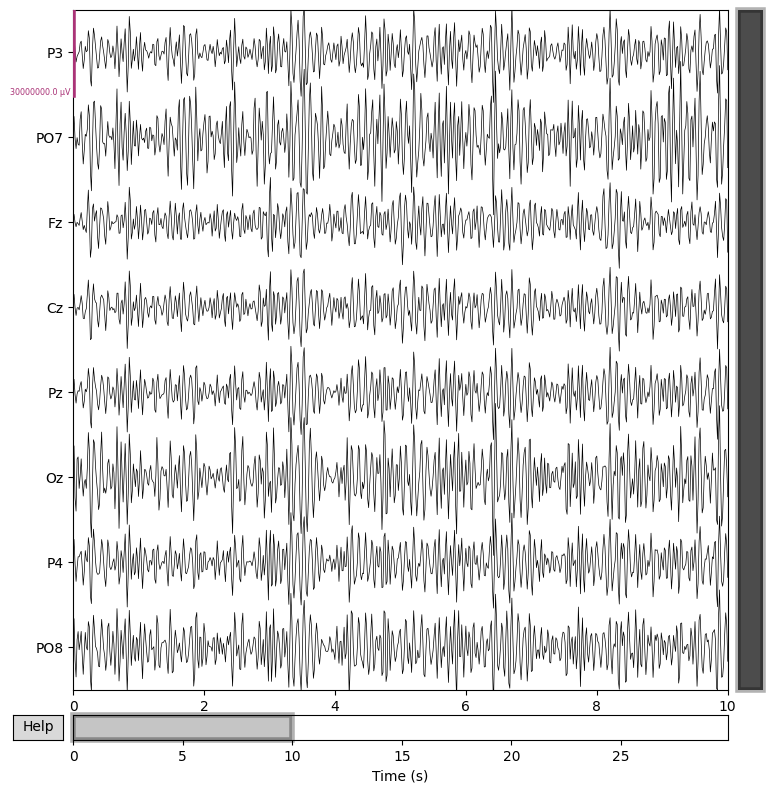

Patient 2
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



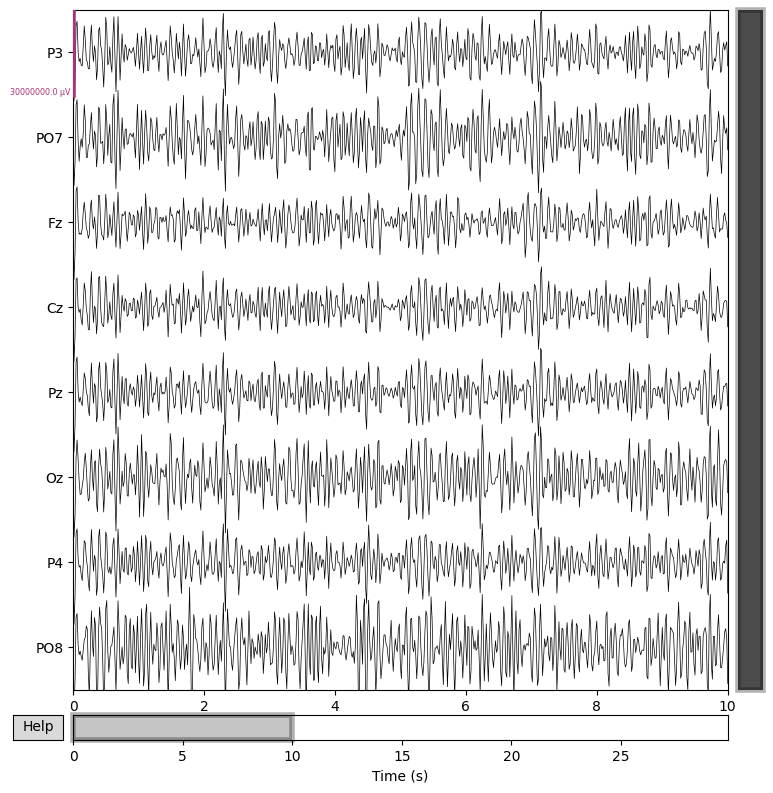

Patient 3
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



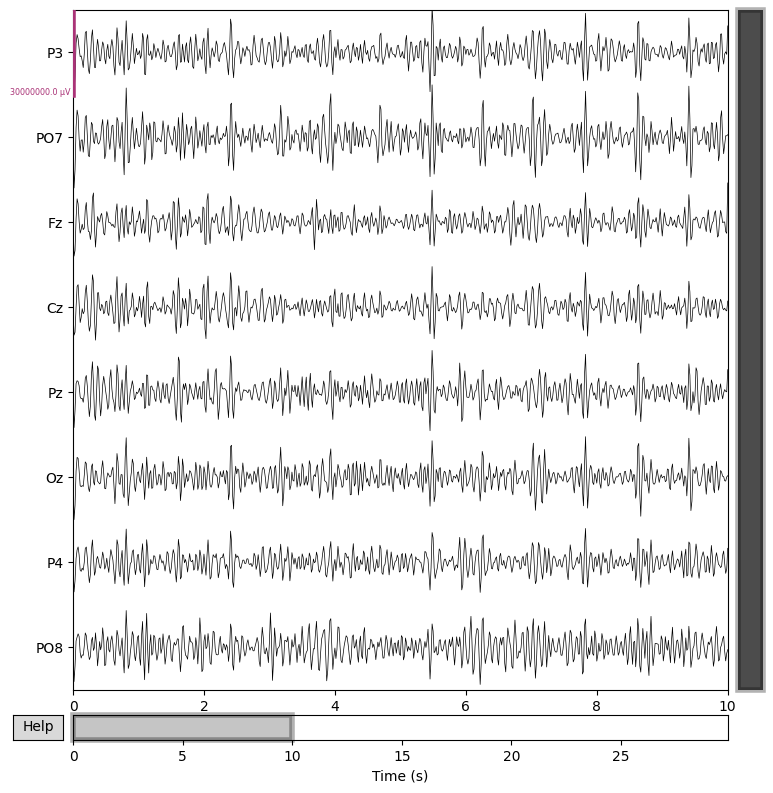

Patient 4
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



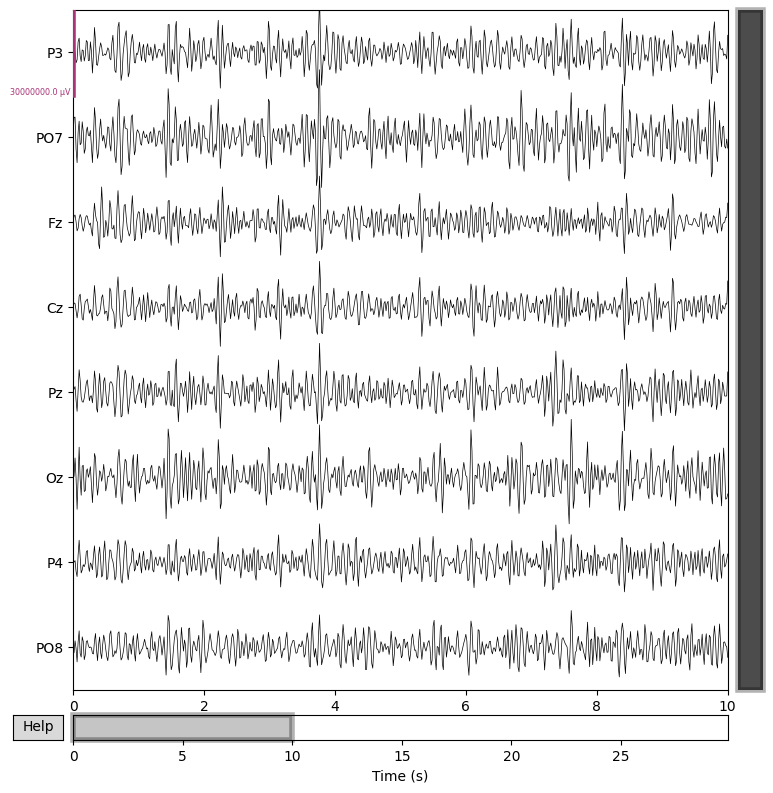

Patient 5
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



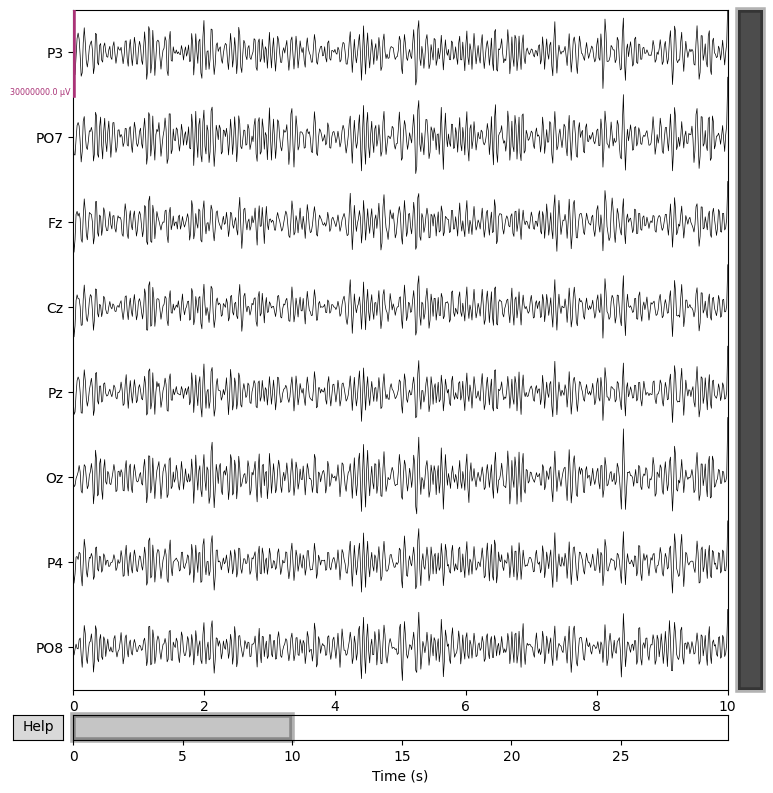

Patient 6
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



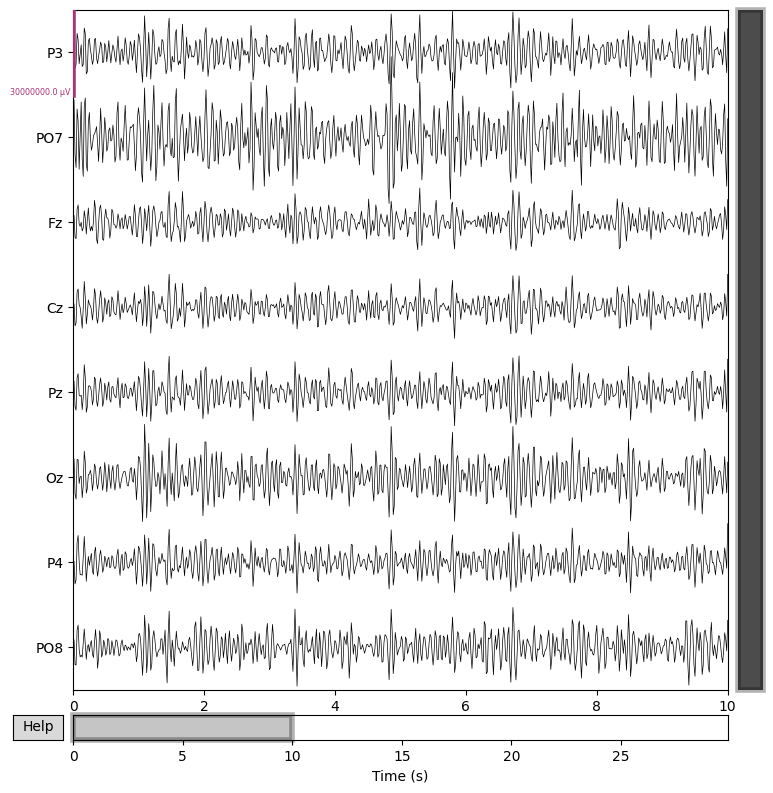

Patient 7
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



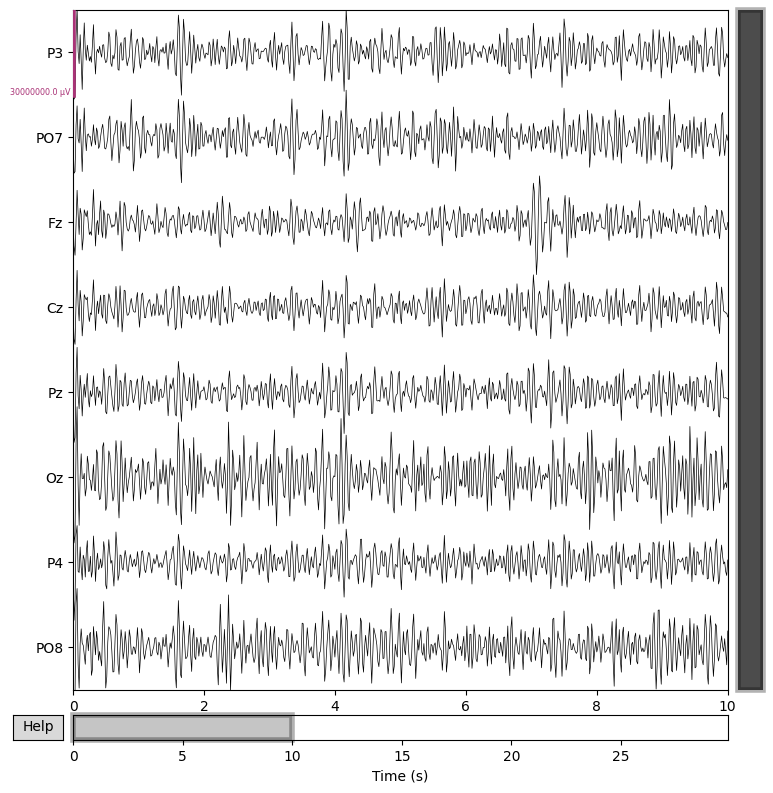

Patient 8
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



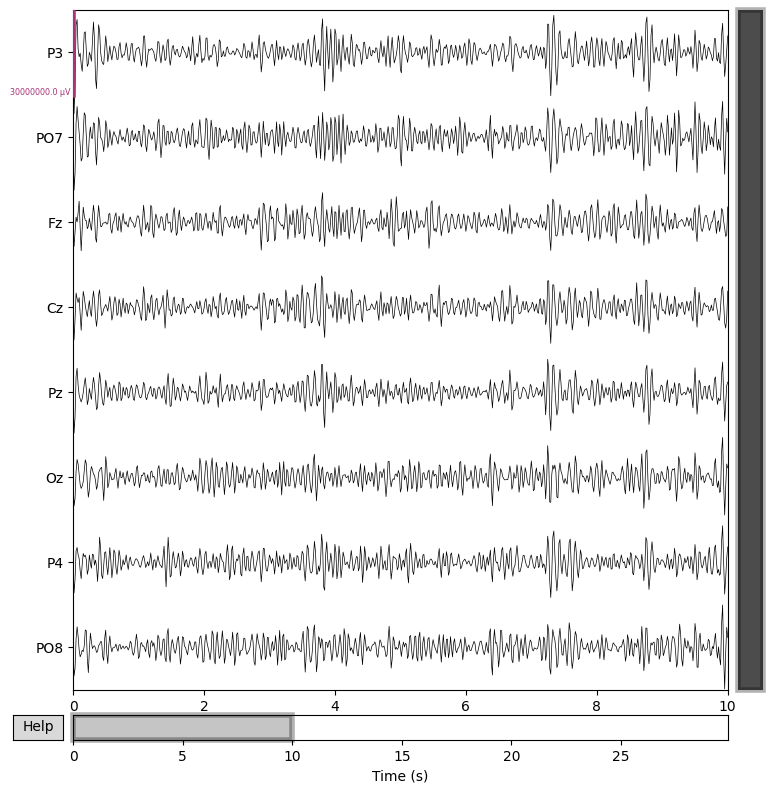

In [17]:
for i in range(x.shape[0]):
    print(f"Patient {i+1}")
    view_signal(x[i, 0, 0, :, :], title=f'Patient {i+1}', lowpass=20, highpass=8, y=y_target[i], scalings=dict(eeg=15))


# Clean the data

In [18]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')


In [ ]:
# Bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4, axis=-1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=axis)
    return y


In [ ]:
# Notch filter
def notch_filter(data, frequency, fs, axis=-1, quality_factor=30.0):
    b, a = iirnotch(frequency, quality_factor, fs)
    return lfilter(b, a, data, axis=axis)


In [21]:
highpass_filter = 0.1 #Hz
lowpass_filter = 10 #Hz
notch_frequency = 50 #Hz

In [22]:
X_filtered = butter_bandpass_filter(x, highpass_filter, lowpass_filter, sample_frequency, order=4, axis=3)
X_filtered = notch_filter(X_filtered, notch_frequency, sample_frequency, axis=3)
print(X_filtered.shape)

(8, 7, 5, 7648, 8)


In [23]:
minimum_amplitude = -70
maximum_amplitude = 70

X_filtered[(X_filtered < minimum_amplitude) | (X_filtered > maximum_amplitude)] = 0
print(X_filtered.shape)

(8, 7, 5, 7648, 8)


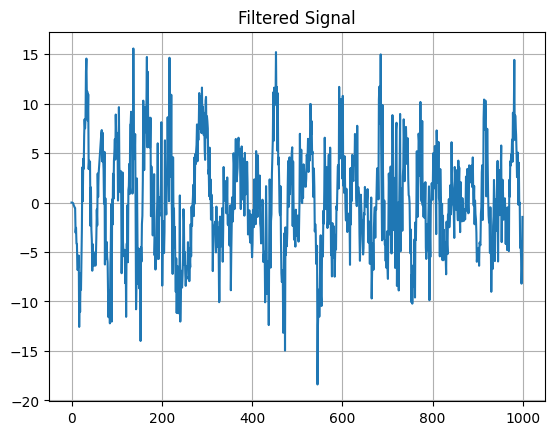

In [24]:
plt.figure()
plt.title("Filtered Signal")
plt.plot(X_filtered.reshape((X_filtered.shape[0], -1, X_filtered.shape[1]))[1, :1000, 0])
plt.grid()
plt.show()

BASELINE CORRECTION

In [26]:
baseline_duration = 200  # ms
epoch_duration = 1000  # ms
baseline_samples = int(sample_frequency * baseline_duration / 1000)
epoch_samples = int(sample_frequency * epoch_duration / 1000)

# Reshape data for processing
X_filtered = X_filtered.reshape((X_filtered.shape[0], -1, X_filtered.shape[-1]))
y_filtered = y_target.reshape((y_target.shape[0], -1))

def apply_baseline_correction(X, y, baseline_samples, epoch_samples):
    """
    Applies baseline correction to EEG data.
    
    Parameters:
        X (ndarray): EEG signal data (Patients x Trials x Channels).
        y (ndarray): Target labels (Patients x Trials).
        baseline_samples (int): Number of samples to use for baseline calculation.
        epoch_samples (int): Number of samples for each epoch.

    Returns:
        X_corrected (ndarray): Baseline-corrected EEG data.
    """
    X_corrected = X.copy()
    for patient in range(X.shape[0]):
        for channel in range(X.shape[-1]):
            i = 0
            while i < X.shape[1]:
                if y[patient, i] != 0:  # Stimulus onset
                    if i > baseline_samples:
                        average = np.mean(X[patient, i-baseline_samples:i, channel])
                    else:
                        average = 0
                    X_corrected[patient, i:i+epoch_samples, channel] -= average
                    i += epoch_samples
                else:
                    i += 1
    return X_corrected

# Apply baseline correction
X_filtered = apply_baseline_correction(X_filtered, y_filtered, baseline_samples, epoch_samples)

# Reshape back to original dimensions
X_filtered = X_filtered.reshape(x.shape)

print("Final shape of X_filtered:", X_filtered.shape)


Final shape of X_filtered: (8, 7, 5, 7648, 8)


Patient 1
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



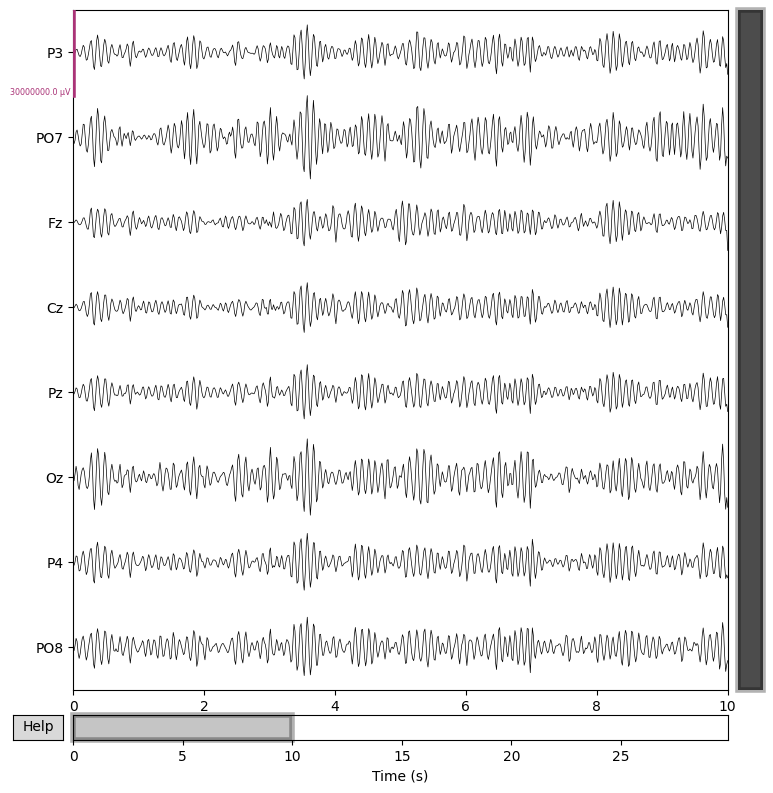

Patient 2
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



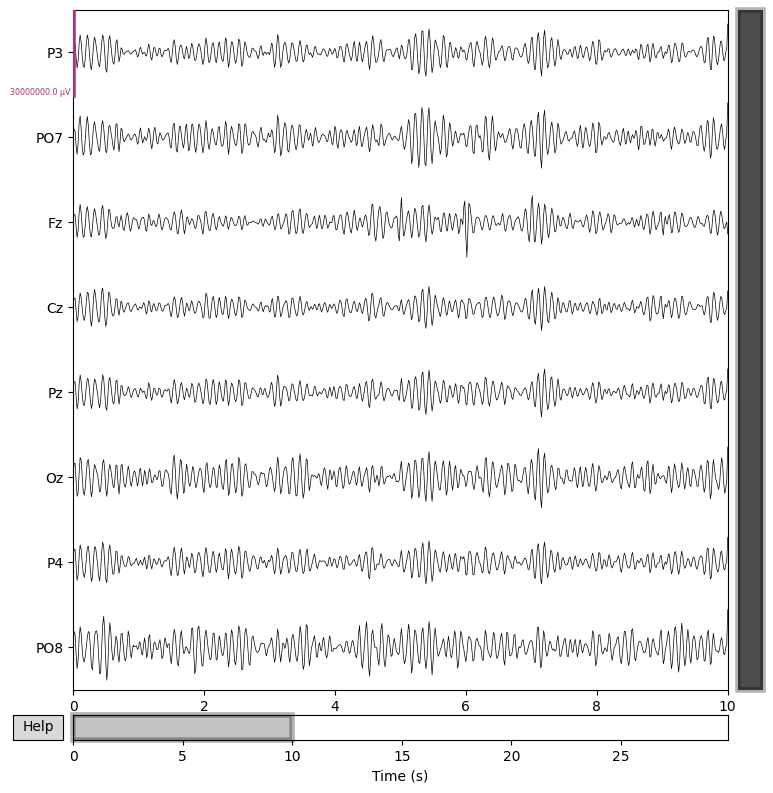

Patient 3
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



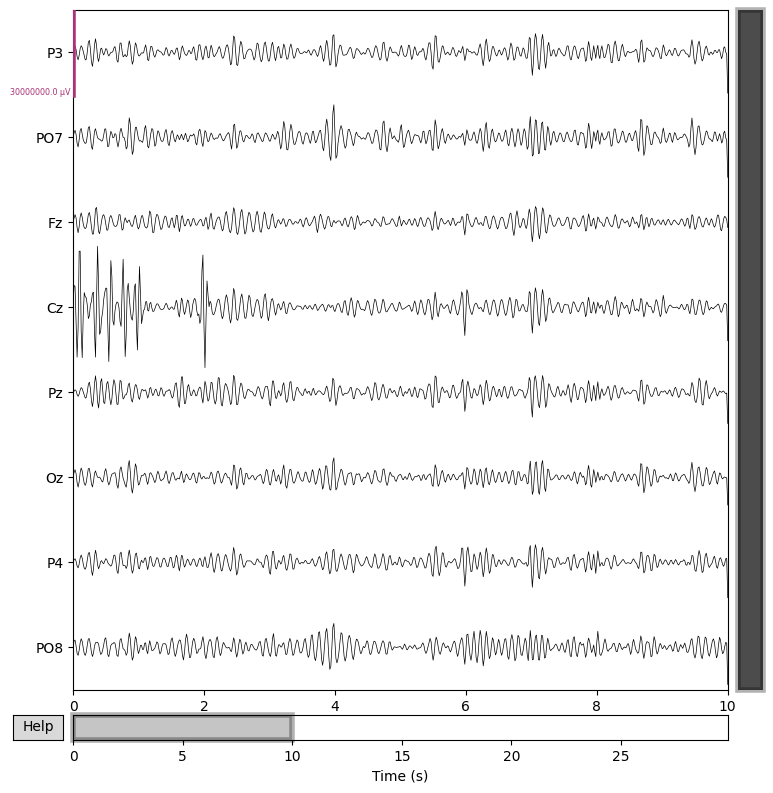

Patient 4
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



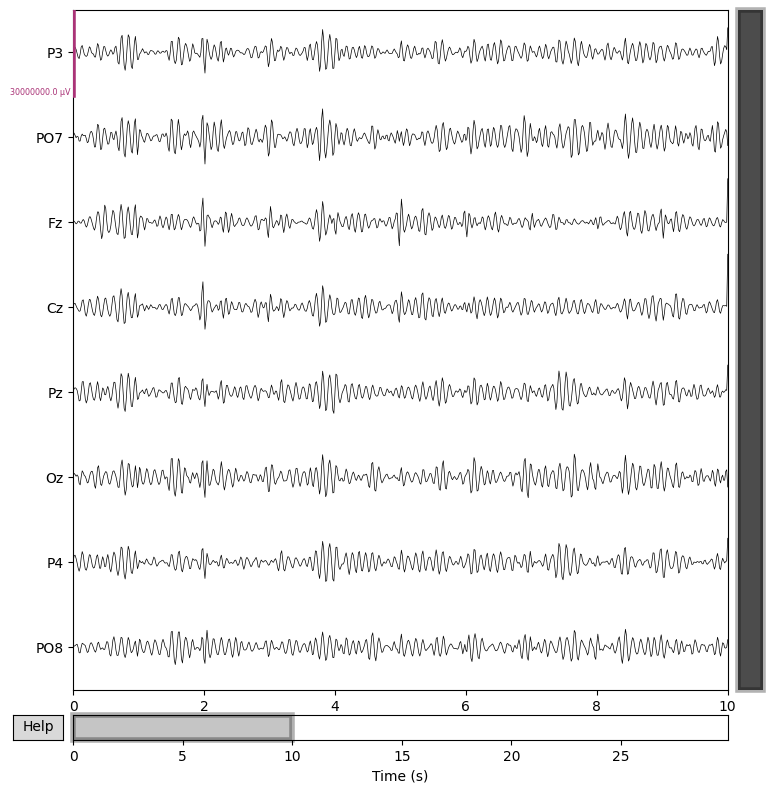

Patient 5
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



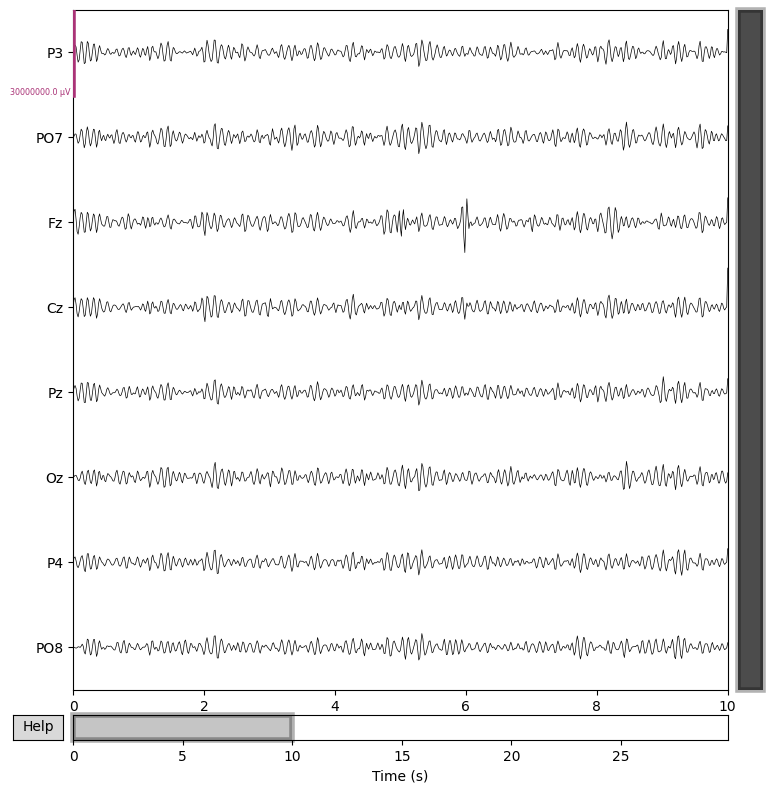

Patient 6
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



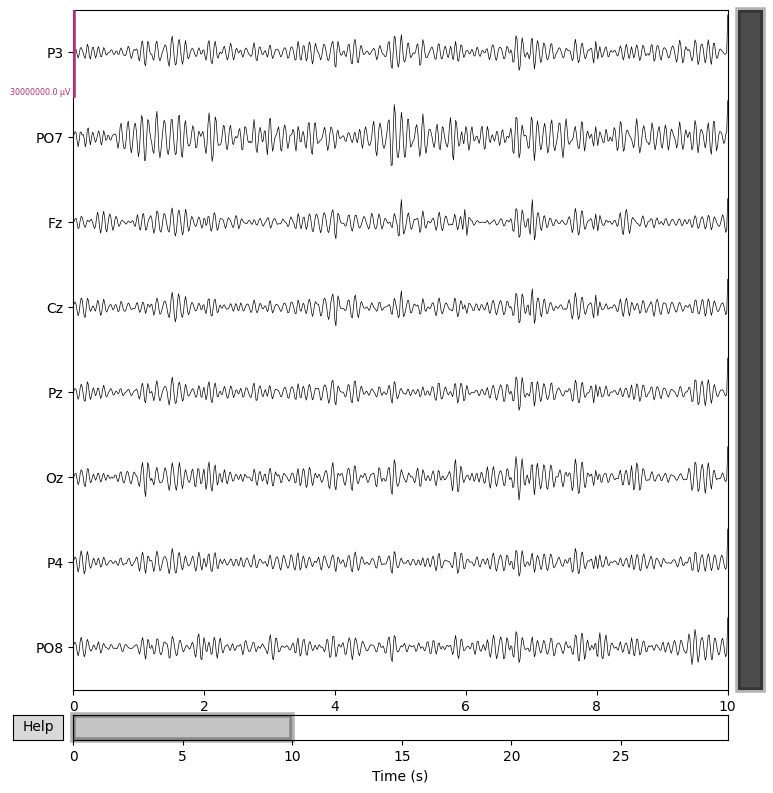

Patient 7
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



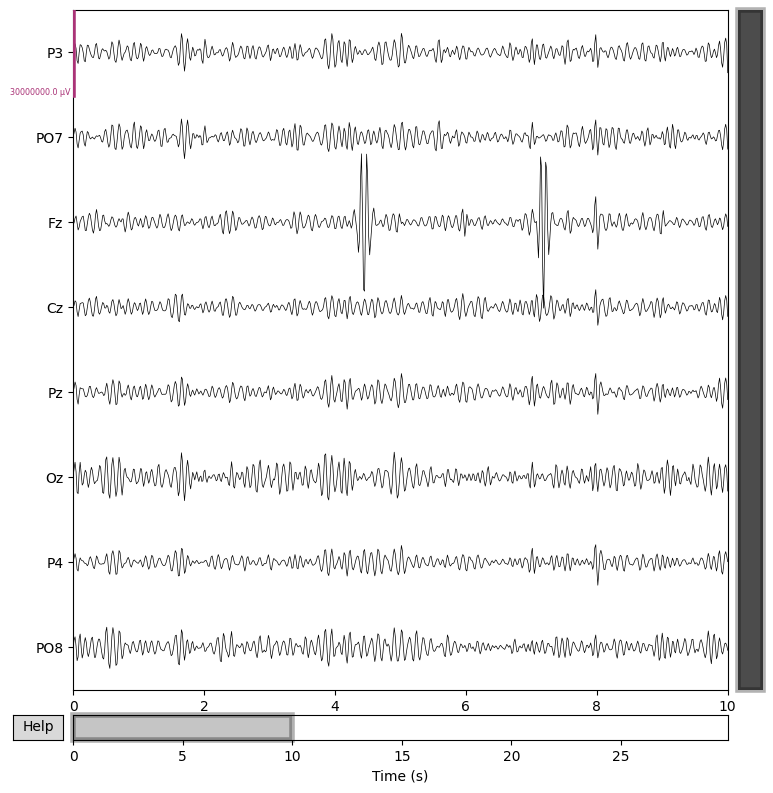

Patient 8
Creating RawArray with float64 data, n_channels=8, n_times=7648
    Range : 0 ... 7647 =      0.000 ...    29.871 secs
Ready.
Setting up band-pass filter from 8 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 20.00 Hz: -6.02, -6.02 dB



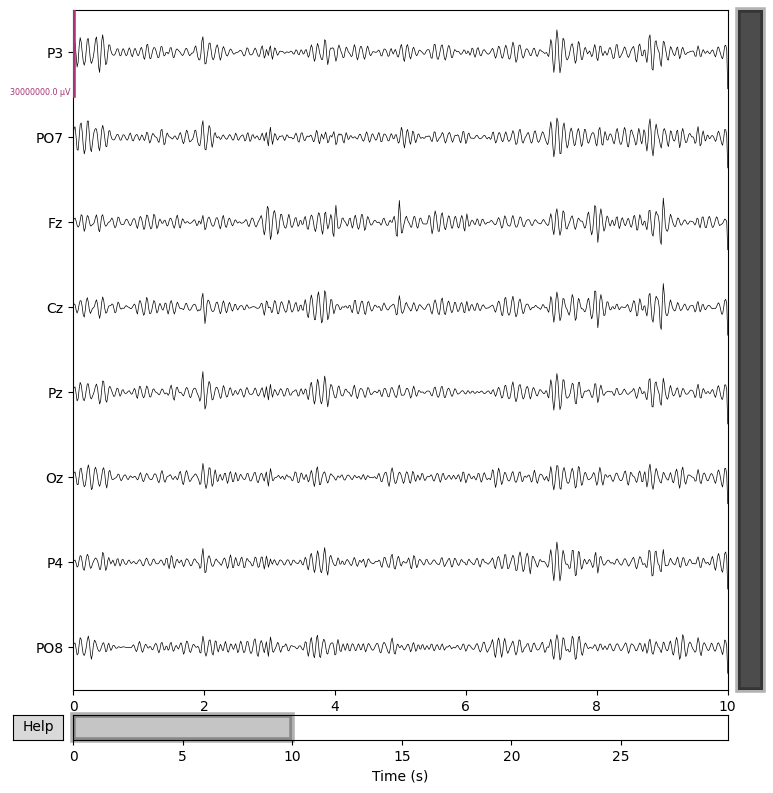

In [28]:
%matplotlib inline
for i in range(x.shape[0]):
    print(f"Patient {i+1}")
    view_signal(X_filtered[i, 0, 0, :, :], title=f'Patient {i+1}', lowpass=20, highpass=8, y=y_target[i], 
                scalings=dict(eeg=15))


(700, 204) (3496, 204)


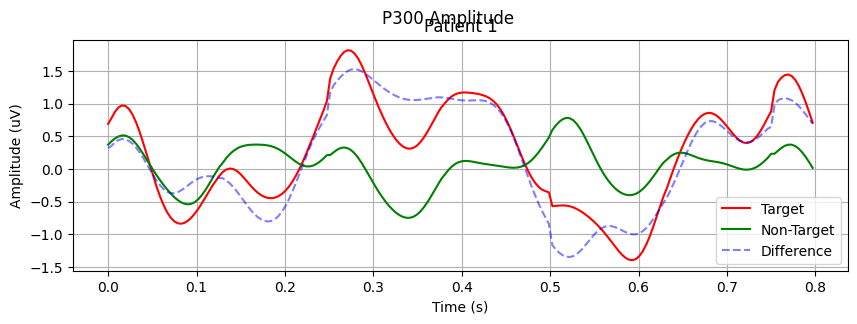

(700, 204) (3496, 204)


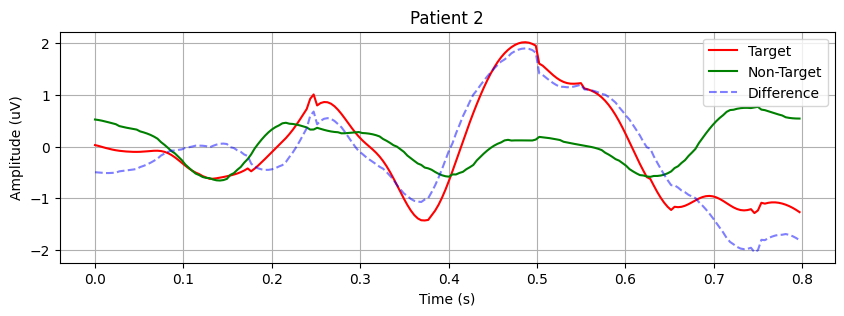

(700, 204) (3496, 204)


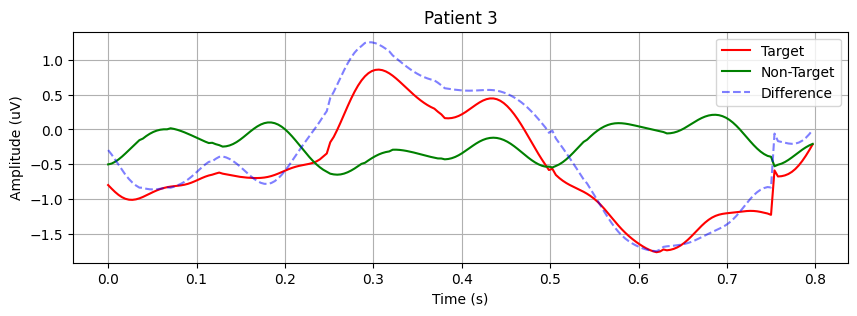

(700, 204) (3496, 204)


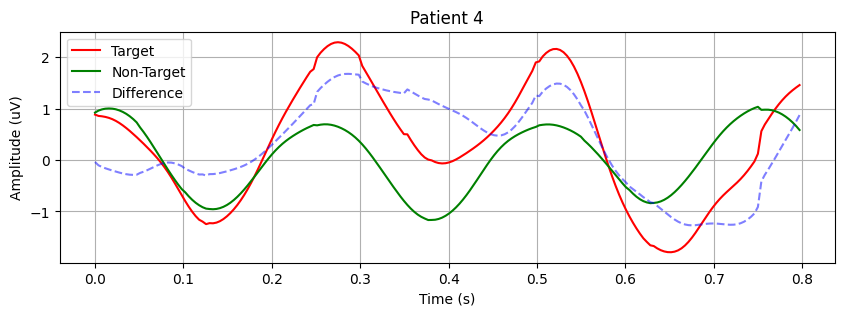

(700, 204) (3496, 204)


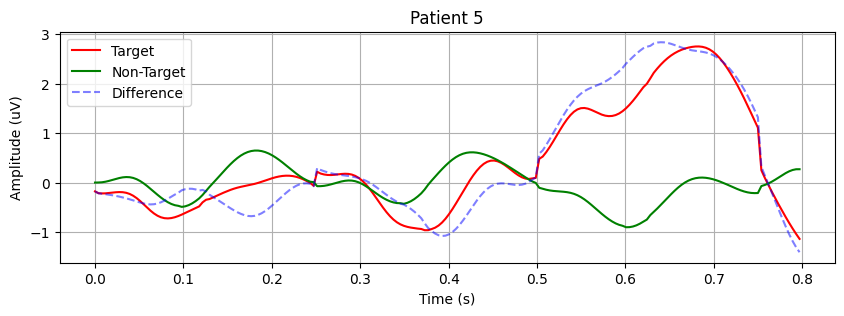

(700, 204) (3496, 204)


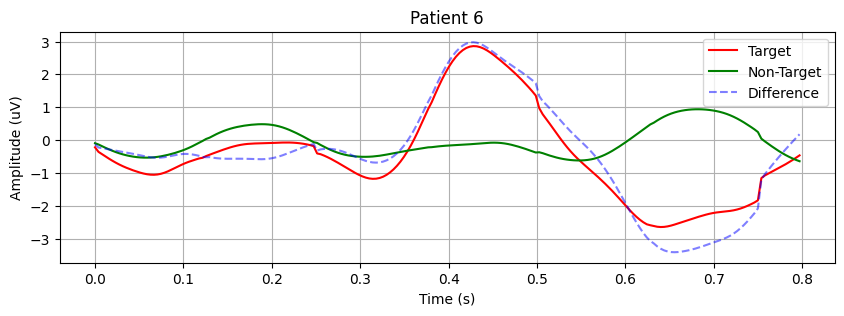

(700, 204) (3496, 204)


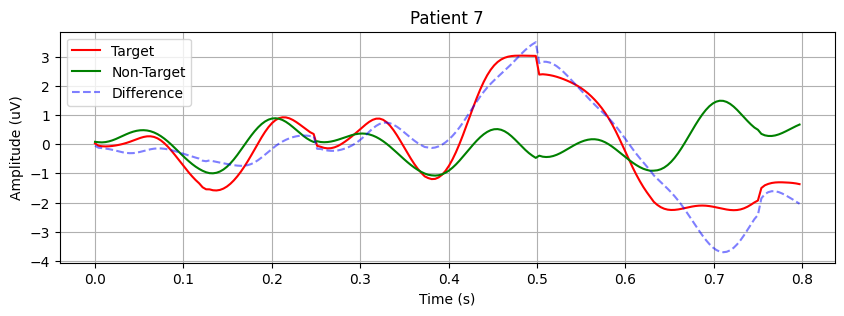

(700, 204) (3496, 204)


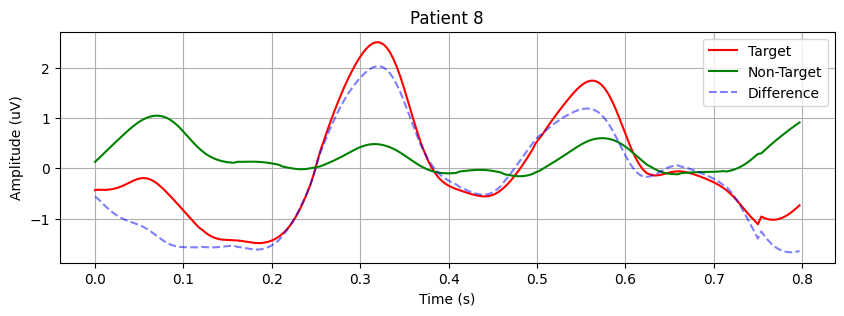

In [29]:
def extract_waveforms(signal, labels, channel_index, start_sample, end_sample):
    """
    Extract target and non-target waveforms from the signal.

    Parameters:
        signal (ndarray): EEG data (flattened signal for a single channel).
        labels (ndarray): Target labels corresponding to the signal.
        channel_index (int): Index of the channel to extract.
        start_sample (int): Start sample offset after onset.
        end_sample (int): End sample offset after onset.

    Returns:
        target_waveforms (ndarray): Extracted target waveforms.
        non_target_waveforms (ndarray): Extracted non-target waveforms.
    """
    target_waveforms, non_target_waveforms = [], []

    for j in range(1, labels.size):
        # Check for stimulus onset
        if labels[j] != 0 and labels[j - 1] != labels[j]:
            if j + end_sample < labels.size:
                waveform = signal[j + start_sample:j + end_sample]
                if labels[j] == 1:
                    non_target_waveforms.append(waveform)
                else:
                    target_waveforms.append(waveform)

    return np.array(target_waveforms), np.array(non_target_waveforms)


def plot_waveforms(target_waveforms, non_target_waveforms, patient_index, sample_frequency):
    """
    Plot the averaged target and non-target waveforms.

    Parameters:
        target_waveforms (ndarray): Extracted and averaged target waveforms.
        non_target_waveforms (ndarray): Extracted and averaged non-target waveforms.
        patient_index (int): Patient number for title.
        sample_frequency (int): Sampling frequency of the signal.
    """
    # Compute the x-axis (time in seconds)
    x_axis = np.linspace(0, target_waveforms.shape[0] / sample_frequency, target_waveforms.shape[0])

    # Plotting
    plt.figure(figsize=(10, 3))
    if patient_index == 0:
        plt.suptitle("P300 Amplitude")
    plt.title(f"Patient {patient_index + 1}")

    plt.plot(x_axis, target_waveforms, 'r-', label='Target')
    plt.plot(x_axis, non_target_waveforms, 'g-', label='Non-Target')
    plt.plot(x_axis, target_waveforms - non_target_waveforms, 'b--', alpha=0.5, label='Difference')

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")
    plt.legend()
    plt.grid()
    plt.subplots_adjust(hspace=0.5)
    plt.show()


# Parameters
waveform_start_time_after_onset = 0  # ms
waveform_end_sample_after_onset = 17 * 12  # Samples
waveform_start_sample_after_onset = int(sample_frequency * waveform_start_time_after_onset / 1000)

# Process each patient
for i in range(X_filtered.shape[0]):
    # Extract the channel signal and labels
    signal = X_filtered[i, :, :, :, get_channel_index(patient_data[0], 'Cz')].reshape(-1)
    labels = y_target[i].reshape(-1)

    # Extract waveforms
    target_waveforms, non_target_waveforms = extract_waveforms(
        signal, labels, 
        get_channel_index(patient_data[0], 'Cz'), 
        waveform_start_sample_after_onset, 
        waveform_end_sample_after_onset
    )

    print(target_waveforms.shape, non_target_waveforms.shape)

    # Compute the mean waveforms
    target_waveforms_mean = np.mean(target_waveforms, axis=0)
    non_target_waveforms_mean = np.mean(non_target_waveforms, axis=0)

    # Plot waveforms
    plot_waveforms(target_waveforms_mean, non_target_waveforms_mean, i, sample_frequency)


In [31]:
X_filtered.shape, y_target.shape

((8, 7, 5, 7648, 8), (8, 7, 5, 7648))

In [32]:
import os
import pickle

# Function to create or clean a folder
def create_or_clean_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    else:
        # Clean the folder by removing all files
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                os.remove(file_path)

# Save an object to a pickle file
def save_to_pickle(file_path, obj):
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

# Folder and file setup
folder_path = 'cleaned_data'
create_or_clean_folder(folder_path)

# File paths for saving
x_file_path = os.path.join(folder_path, 'x.pkl')
y_file_path = os.path.join(folder_path, 'y.pkl')  # Fix the filename to be meaningful

# Save data to pickle files
save_to_pickle(x_file_path, X_filtered)
save_to_pickle(y_file_path, y_target)
